In [1]:
import sys
sys.path.append('../..')
import argparse
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from bundlenet_continuous_variant import BunDLeNet, train_model
from functions import preprocess_data, prep_data, plotting_neuronal_behavioural, plot_latent_timeseries, timeseries_train_test_split
from plotting_functions import plot_phase_space

import os
os.chdir('../..')

%reload_ext autoreload
%autoreload 2
os.getcwd()

2024-03-25 16:54:17.796245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 16:54:17.796266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 16:54:17.797185: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 16:54:17.802038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 16:54:18.430846: W tensorflow/compiler/tf2

'/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net'

## Load Data

In [2]:
fish_data_id = '220119_F2_F2_run11' #220119_F2_F2_run11, 220127_F4_F4_run2
path_neuronal_data ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_cells_spike_rate_signals.npy' 
path_behaviour_data1 ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_directionality.npy'
path_behaviour_data2 ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_vigour.npy'

In [3]:
X = np.load(path_neuronal_data).T
B1 = np.load(path_behaviour_data1)
B2 = np.load(path_behaviour_data2)
B = np.c_[B1, B2]

### Remove NaNs
B = B[~np.isnan(X[:,0])]
X = X[~np.isnan(X[:,0])]
B.shape, X.shape

### Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
B = StandardScaler(with_mean=False).fit_transform(B)
X = StandardScaler(with_mean=False).fit_transform(X)

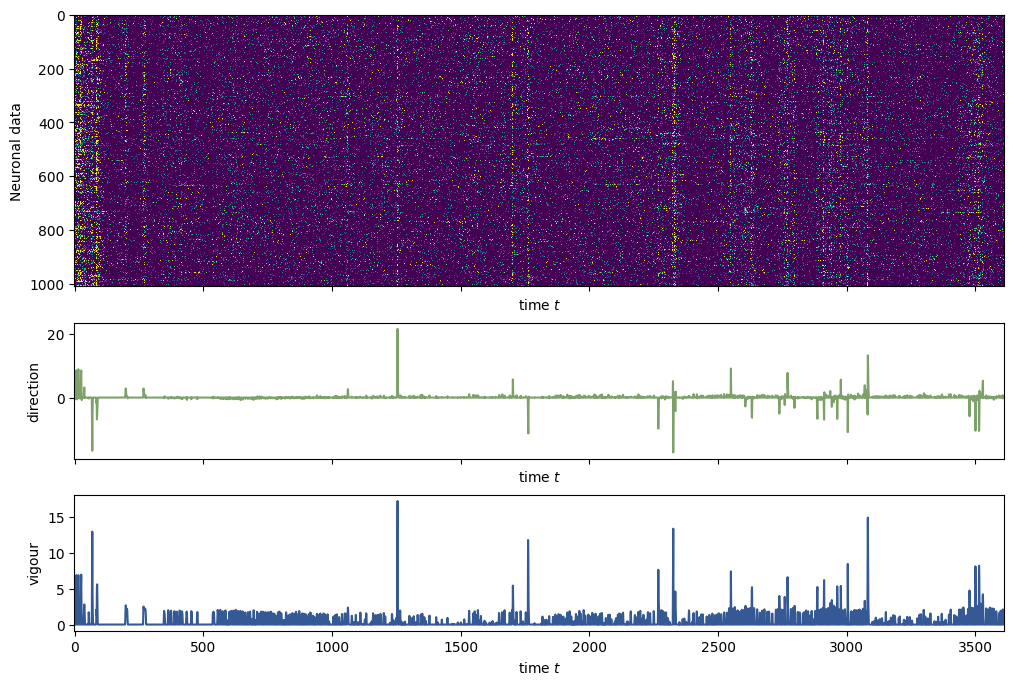

In [4]:
def plotting_neuronal_behavioural(X,B, state_names=[], **kwargs):
    fig, axs = plt.subplots(3,1,figsize=(12,8),  sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
    im0 = axs[0].imshow(X.T,aspect='auto', interpolation='None', **kwargs)
    # tell the colorbar to tick at integers
    axs[0].set_xlabel("time $t$")
    axs[0].set_ylabel("Neuronal data")
    
    colors = ['#7EA16B', '#345995', '#AF125A']
    ylabels = ['direction', 'vigour']
    for i in range(2):
        # Behaviour 1
        im1 = axs[i+1].plot(B[:,i], c=colors[i])
        axs[i+1].set_xlabel("time $t$")
        axs[i+1].set_ylabel(ylabels[i])
        #axs[i+1].set_yticks([])

    plt.show()
    
plotting_neuronal_behavioural(X,B, vmin=0, vmax=5)

## BunDLe-Net

In [7]:
algorithm = 'BunDLeNet'
X_, B_ = prep_data(X, B, win=1)

### Deploy BunDLe Net
model = BunDLeNet(latent_dim=3, num_behaviour=B_.shape[1])
model.build(input_shape=X_.shape)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

X_train, X_test, B_train_1, B_test_1 = timeseries_train_test_split(X_, B_)
train_history, test_history = train_model(
    X_train,
    B_train_1,
    model,
    optimizer,
    gamma=0.9, 
    n_epochs=200,
    pca_init=False,
    best_of_5_init=False,
    validation_data = (X_test, B_test_1)
)

'''
train_history, _ = train_model(
    X_,
    B_, 
    model,
    optimizer,
    gamma=0.5, 
    n_epochs=500,
    pca_init=False,
    best_of_5_init=False
)
'''

2024-03-25 17:05:54.282835: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 17:05:54.283043: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 17:05:54.283177: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

InternalError: cudaSetDevice() on GPU:0 failed. Status: out of memory

<IPython.core.display.Javascript object>


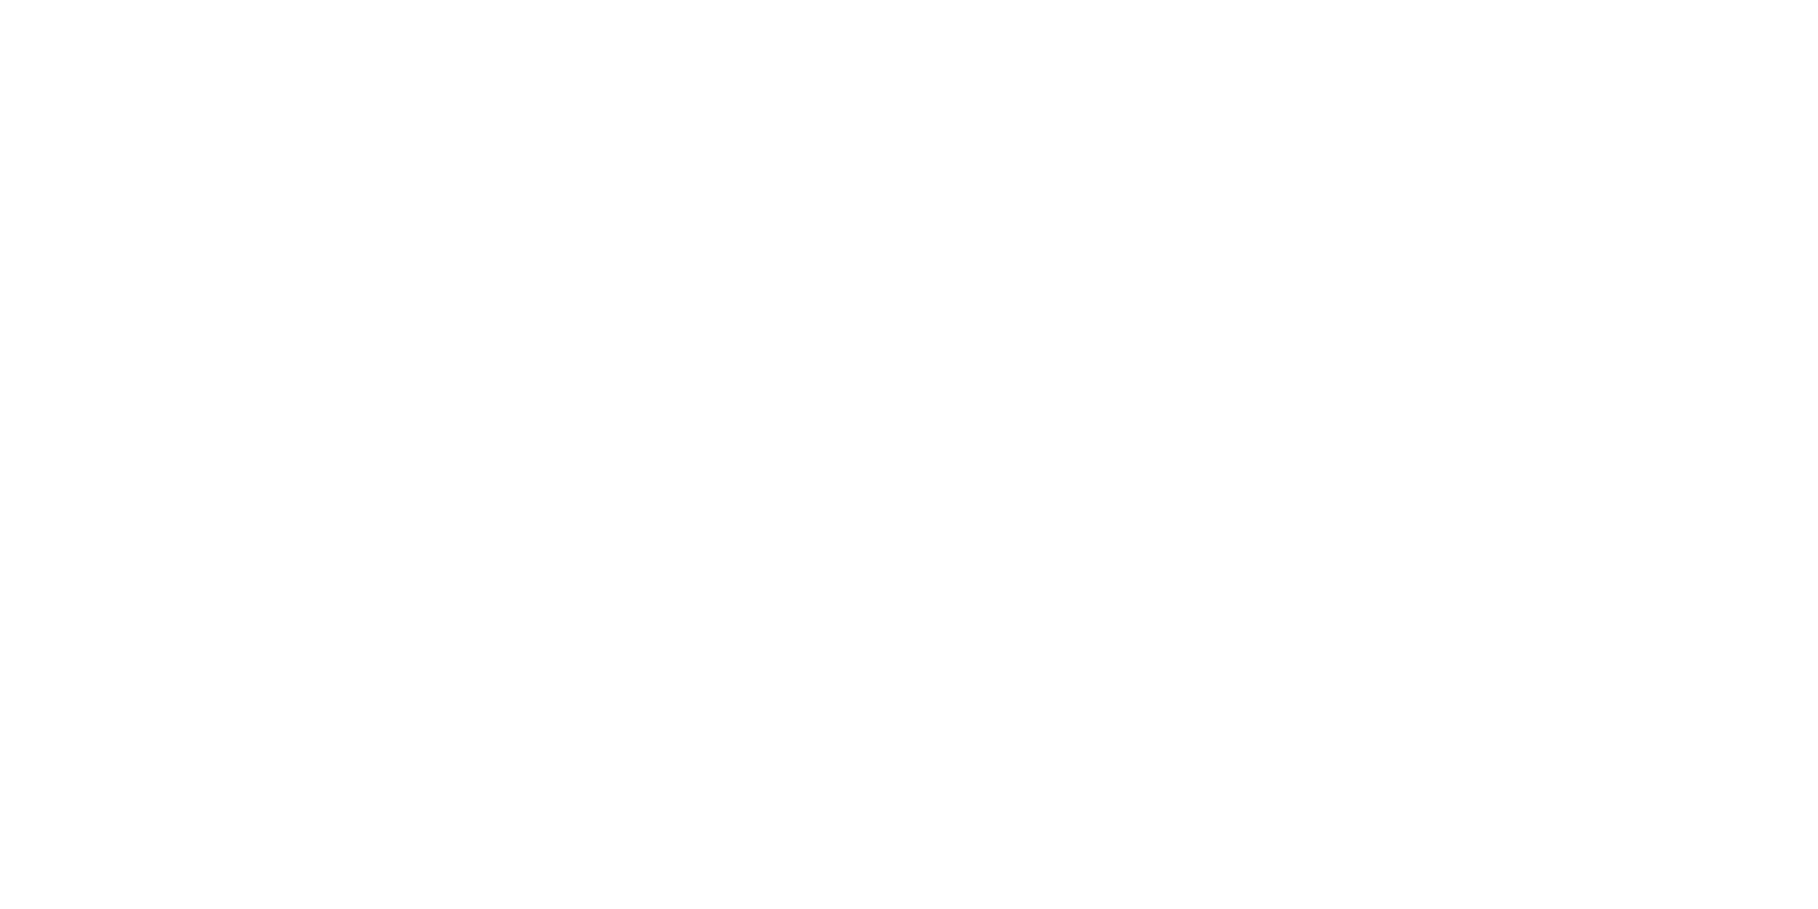

<IPython.core.display.Javascript object>


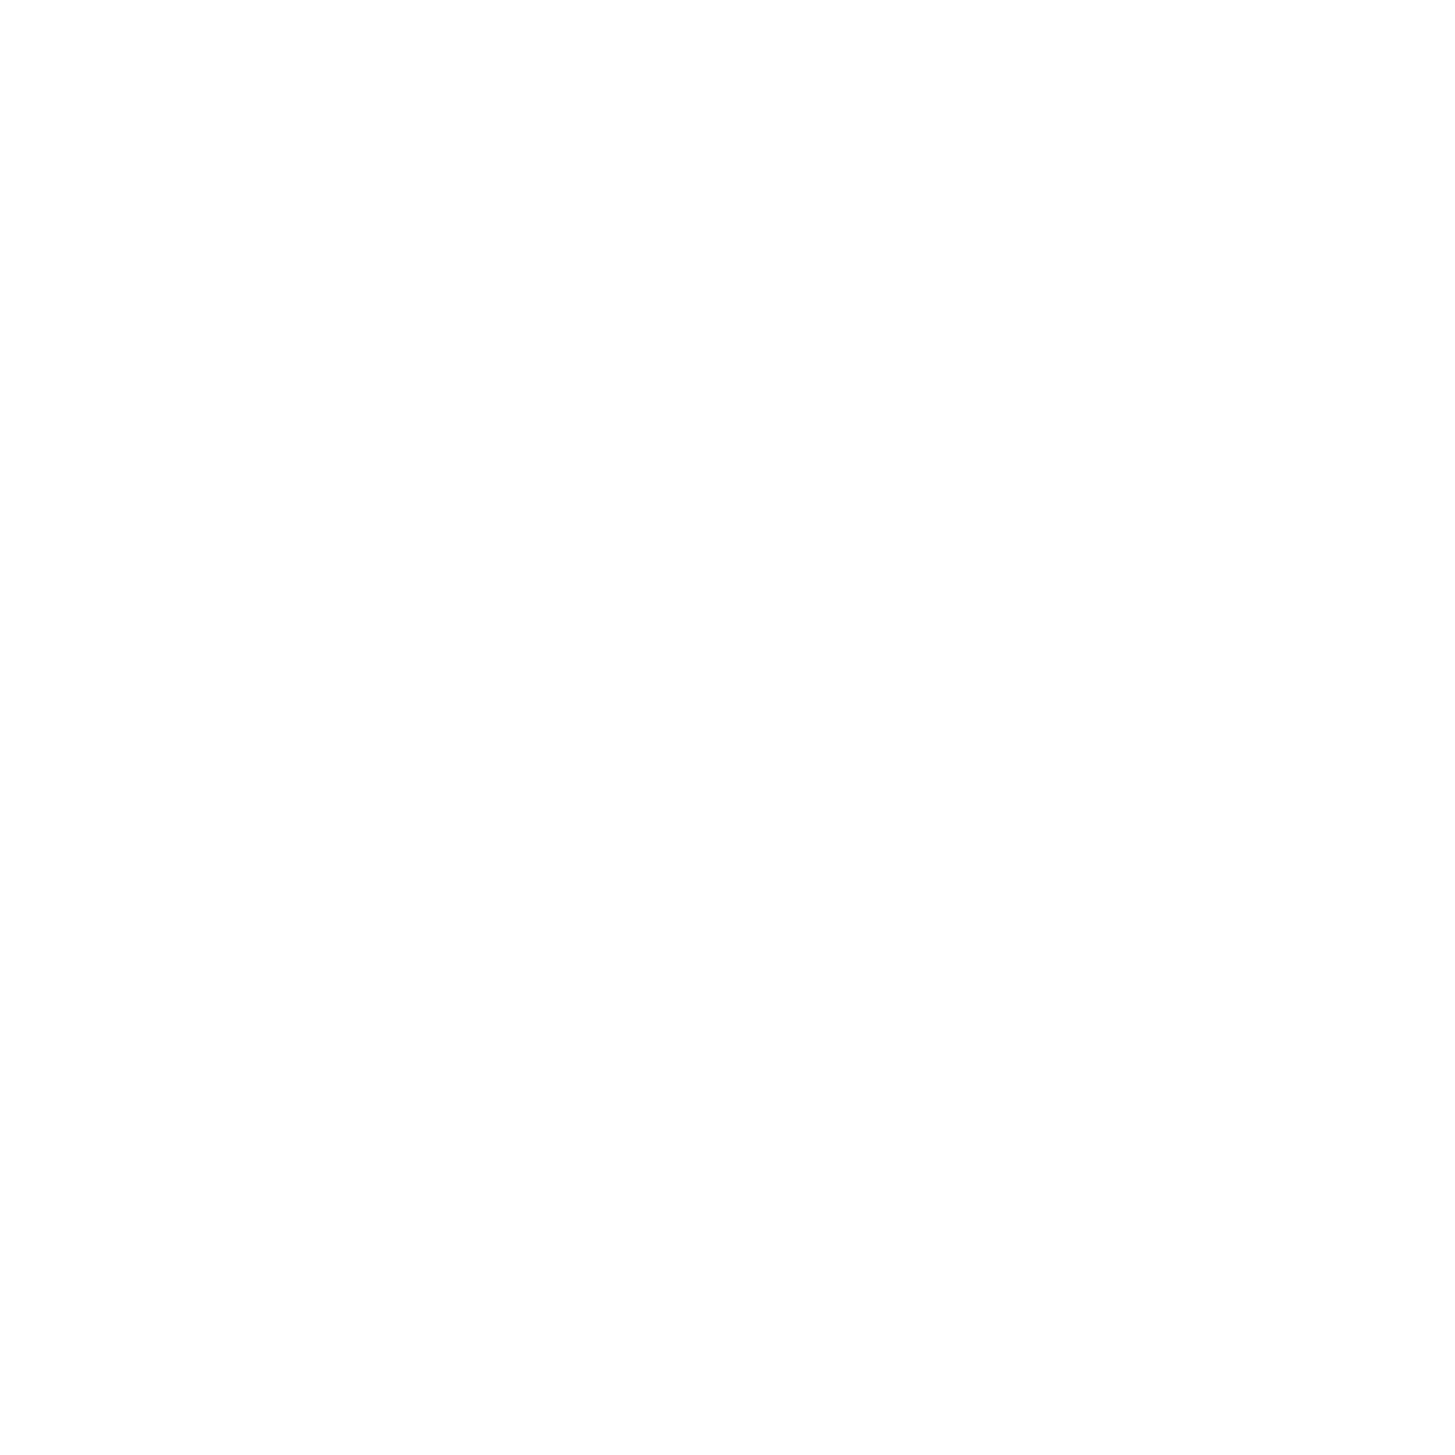

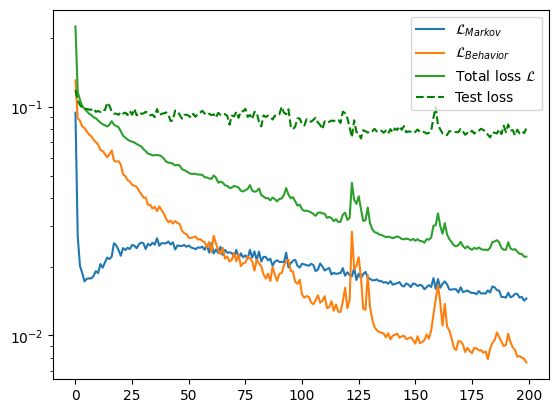

In [16]:
%matplotlib inline
# Training losses vs epochs
plt.figure()
for i, label in  enumerate(["$\mathcal{L}_{{Markov}}$", "$\mathcal{L}_{{Behavior}}$","Total loss $\mathcal{L}$" ]):
    plt.semilogy(train_history[:,i], label=label)

plt.semilogy(test_history[:,-1], label="Test loss", linestyle="--", color='g')       
plt.legend()
plt.show()

## Projecting into latent space

In [17]:
### Projecting into latent space
Y0_ = model.tau(X_[:,0]).numpy()
Y0_.shape

(3612, 3)

In [186]:
os.makedirs('data/generated/saved_Y/fish', exist_ok=True)
np.savetxt('data/generated/saved_Y/fish/Y0__' + algorithm + '_fish_' + fish_data_id, Y0_)
np.savetxt('data/generated/saved_Y/fish/B__' + algorithm + '_fish_' + fish_data_id, B_)

In [187]:
Y0_ = np.loadtxt('data/generated/saved_Y/fish/Y0__' + algorithm + '_fish_' + fish_data_id)
B_ = np.loadtxt('data/generated/saved_Y/fish/B__' + algorithm + '_fish_' + fish_data_id)

## Visualising embedding

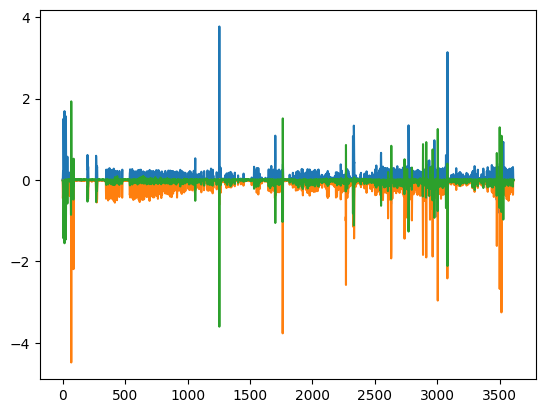

In [18]:
%matplotlib inline
plt.figure()
plt.plot(Y0_)

<IPython.core.display.Javascript object>


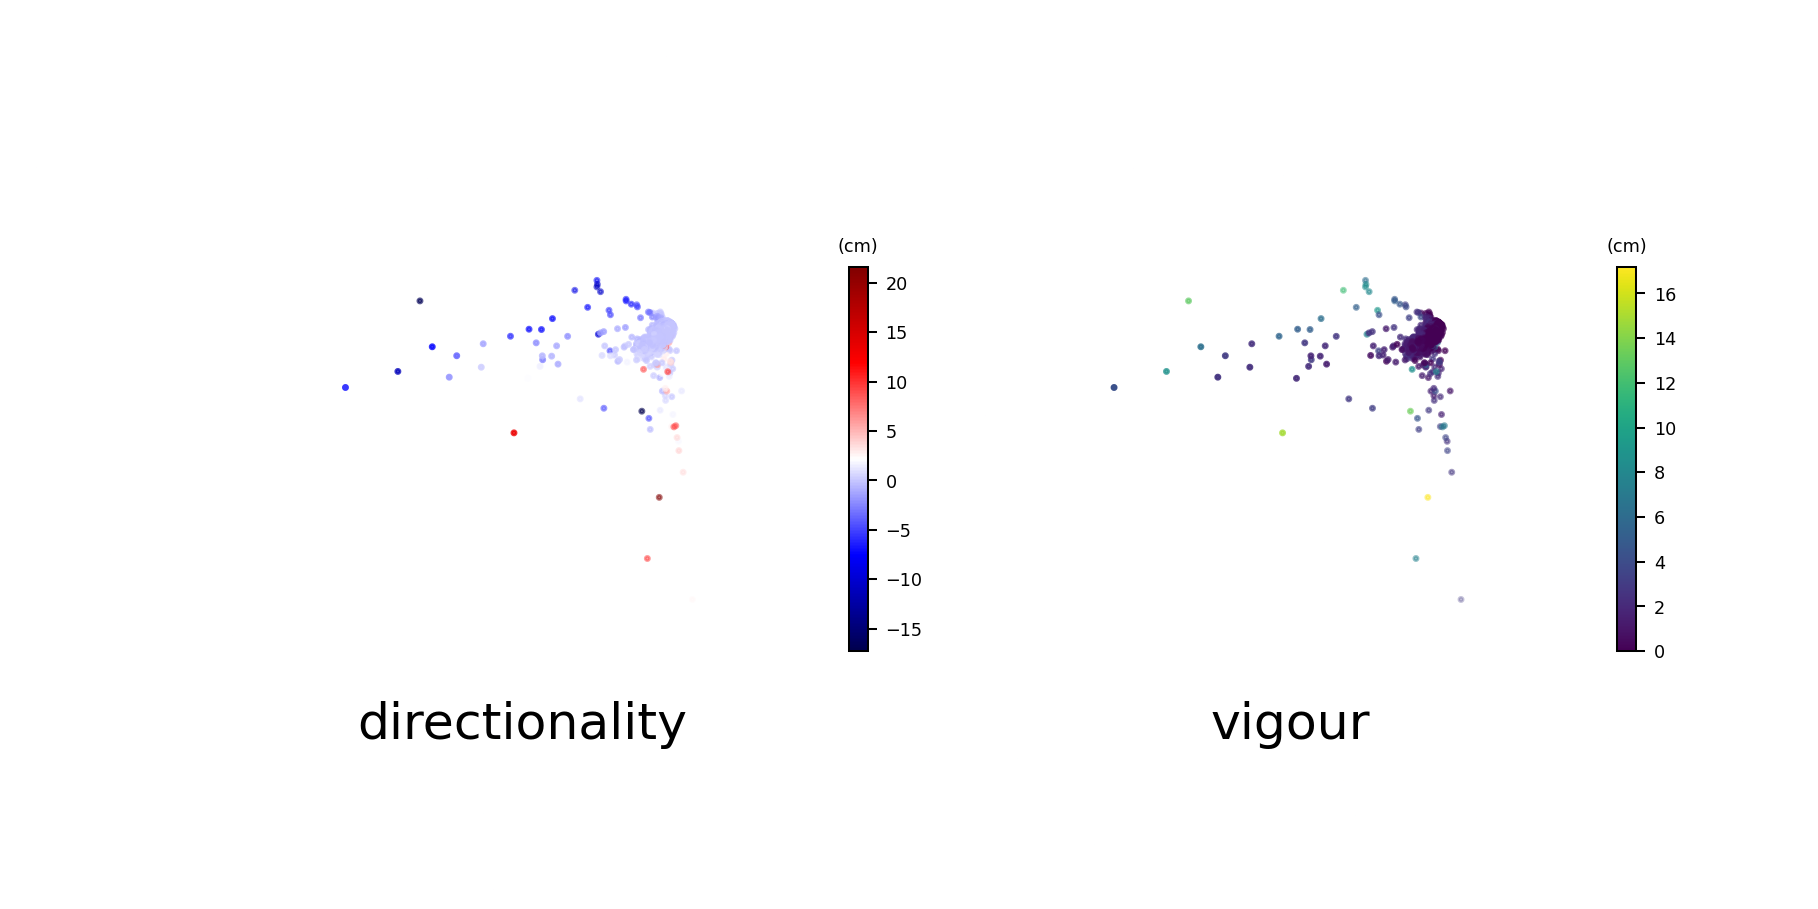

In [19]:
%matplotlib notebook
def plot_embedding(Y0_, B_, title=None, **kwargs):
    elev, azim, roll = 27,10,0
    fig = plt.figure(figsize=(10, 5))
    plt.suptitle(title,
                 fontsize=20)
    ax = plt.subplot(121, projection = '3d')
    ax.view_init(**kwargs)
    ax.set_title('directionality', fontsize=20, y=0)
    x = ax.scatter(Y0_[:, 0],
                   Y0_[:, 1],
                   Y0_[:, 2],
                   c=B_[:, 0],
                   cmap='seismic',
                   s=3
    )
    ax.axis('off')
    xc = plt.colorbar(x, fraction=0.03, pad=0.05)
    xc.ax.tick_params(labelsize=7)

    ax = plt.subplot(122, projection = '3d')
    ax.view_init(**kwargs)
    y = ax.scatter(Y0_[:, 0],
                   Y0_[:, 1],
                   Y0_[:, 2],
                   c=B_[:, 1],
                   cmap='viridis',
                   s=3
    )
    ax.axis('off')
    ax.set_title('vigour', fontsize=20, y=0)
    yc = plt.colorbar(y, fraction=0.03, pad=0.05)
    yc.ax.tick_params(labelsize=7)
    plt.show()

plot_embedding(Y0_, B_, elev=80, azim=-12 )

<IPython.core.display.Javascript object>


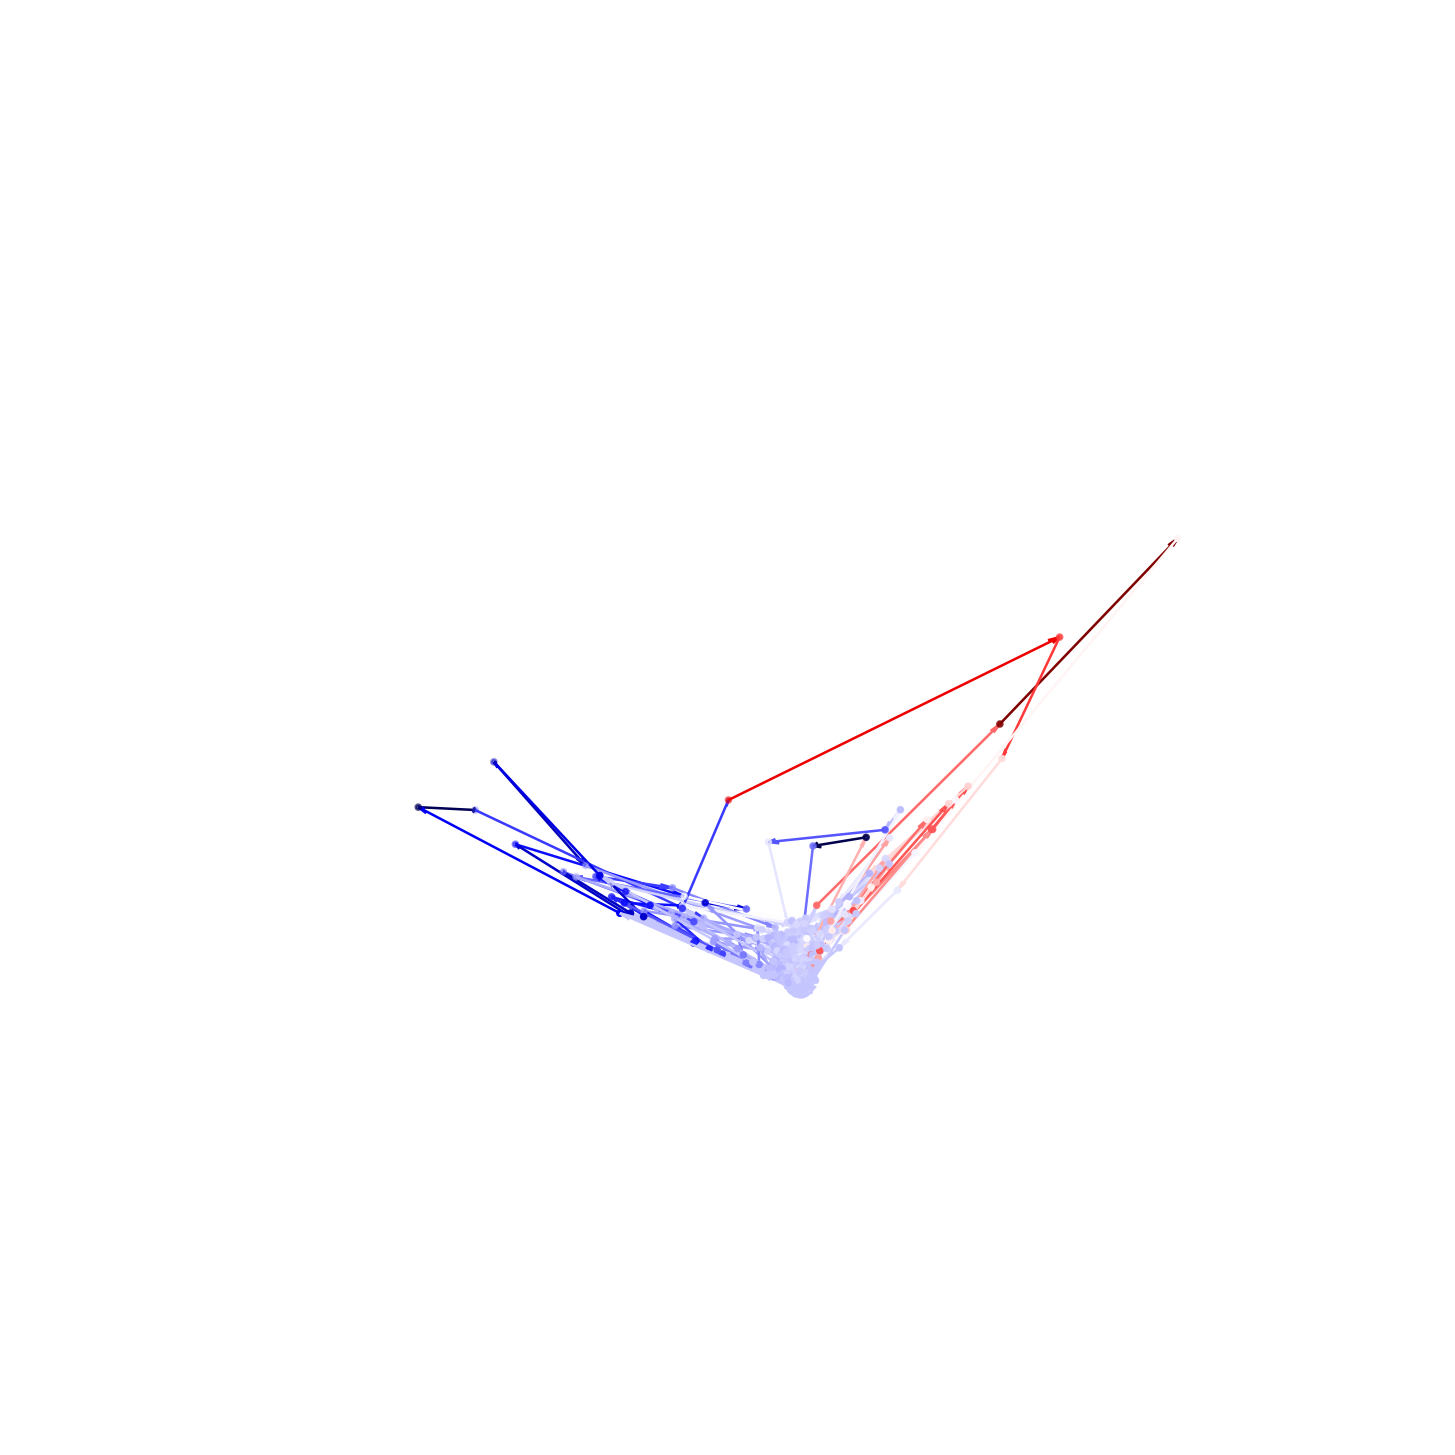

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [20]:
def plot_ps_(fig, ax, Y, B, cmap='viridis'):
    
    def color_transform(a, cmap=cmap):
        normalized_value = (a - B.min()) / (B.max() - B.min())
        cmap = plt.get_cmap(cmap)
        rgba_color = cmap(normalized_value)
        rgb_color = rgba_color[:3]

        return rgb_color
    
    for i in range(len(Y) - 1):
        d = (Y[i+1] - Y[i])
        ax.quiver(Y[i, 0], Y[i, 1], Y[i, 2],
                  d[0], d[1], d[2],
                  color=color_transform(B[i]), arrow_length_ratio=0.1/np.linalg.norm(d), linewidths=1)
    ax.set_axis_off()  

    x = ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2],
                   c=B,
                   cmap=cmap,
                   s=4)
    return fig, ax

def plot_phase_space(Y, B, cmap='viridis', **kwargs):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.view_init(**kwargs)
    plot_ps_(fig, ax, Y, B, cmap)
    plt.show()
    return fig, ax

def rotating_plot(Y, B, cmap, filename='rotation.gif'):
    import matplotlib.animation as animation
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')

    def rotate(angle):
        ax.view_init(azim=angle)

    fig, ax = plot_ps_(fig, ax, Y=Y, B=B, cmap=cmap)
    rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 5), interval=150)
    rot_animation.save(filename, dpi=150, writer='imagemagick')
    plt.show()
    return ax

plot_phase_space(Y0_, B_[:,0],  elev=80, azim=-12, cmap='seismic')

<IPython.core.display.Javascript object>


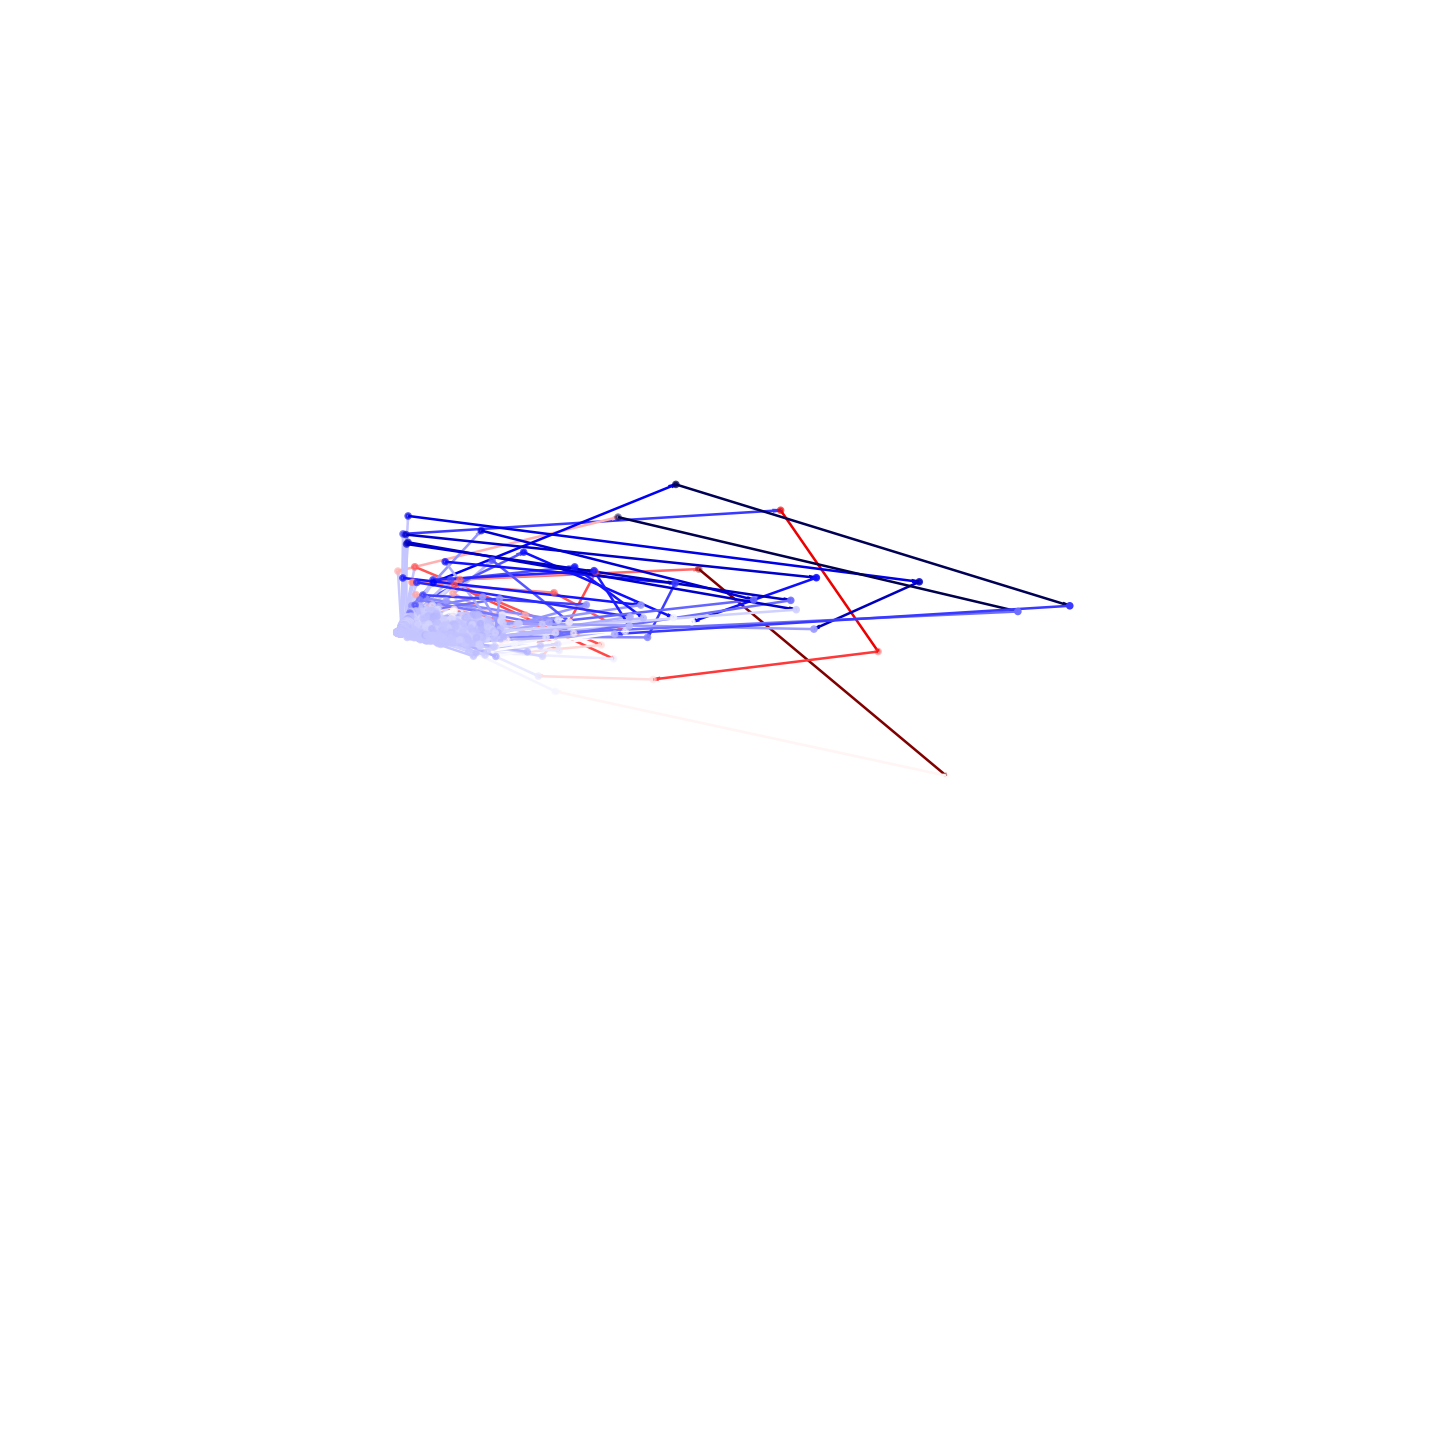

/tmp/ipykernel_471733/3146946992.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  color=color_transform(B[i]), arrow_length_ratio=0.1/np.linalg.norm(d), linewidths=1)


<Axes3D: >

In [191]:
rotating_plot(
    Y0_, 
    B_[:,0], 
    cmap='seismic', 
    filename='experimental/bundle_net_on_fish/rotation_'+ algorithm + '_fish_' + fish_data_id +'.gif'
)

In [ ]:
plot_phase_space(Y0_, B_[:,0], cmap='seismic', elev=80, azim=-12)

## Behaviour predictor

In [ ]:
B1_pred = model.predictor(Y0_).numpy()
plt.figure()
plt.plot(B_pred[:200, 0])
plt.plot(B_[:200, 0])

---------------------

# Comparision with other embedding algorithms

## PCA

In [ ]:
from sklearn.decomposition import PCA
dim = 3
pca = PCA(n_components=dim)
pca.fit(X_[:,0,0,:]) ###################### use X instead of X_
print('Percentage of variance explained by the first ', dim, ' PCs: ', pca.explained_variance_ratio_[:dim].sum().round(3))

### Projecting into latent space
Y0_pca = pca.transform(X_[:,0,0,:])

In [ ]:
%matplotlib notebook

plot_embedding(Y0_pca, B_, elev=120, azim=-38 )

In [ ]:
plot_phase_space(Y0_pca, B_[:,1], elev=120, azim=-38 )